In [71]:
from sklearn.preprocessing import OneHotEncoder
from user_agents import parse

import pandas as pd
import random
import os
import numpy as np
import ipaddress
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42
def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()
path2data = 'part_10.csv'
data = pd.read_csv(path2data)
data.shape

def check_ip(ip):
    try:
        ipaddress.ip_address(ip)
    except ValueError:
        return False
    else:
        return True

def spit_by_user_agent(row):
    # Некоторые User-Agent с приставкой "User-Agent: "
    try:
        if "User-Agent: " in row:
            splited = row.split("User-Agent: ")
            return splited[1]
        else:
            return row
    except:
        return row
    
def get_invalid_size(row):
    try:
        int(row)
        return False
    except:
        return True

def get_invalid_code(row):
    try:
        if len(str(row))>3:
            return True
        else:
            return False
    except:
        return True
    
def get_user_agent_info(data):
    "Достаем мета инфу с User-Agent"
    browser_family = []
    os_family = []
    device_brand = []
    
    for agent in data['CLIENT_USERAGENT']:
        user_agent = parse(agent)
        browser_family.append(user_agent.browser.family)
        os_family.append(user_agent.os.family)
        device_brand.append(user_agent.device.brand)
        
    return browser_family, os_family, device_brand
    
def prepare_data(data):
    
    # Убираем дубли
    data.drop_duplicates(keep='first', inplace=True)
    #data = data.reset_index(drop=True)
    
    # Поправляем CLIENT_USERAGENT и заполняем пропуски None
    # В данном случае я считаю, что лучше None оставить как отдельный класс
    data['CLIENT_USERAGENT'] = data['CLIENT_USERAGENT'].apply(spit_by_user_agent).fillna('None')
    
    # Формируем фичу на валидность IP
    data['VALID_IP'] = data['CLIENT_IP'].apply(check_ip).astype('int')
    
    # Достаем инфу из User Agent
    browser_family, os_family, device_brand = get_user_agent_info(data)
    
    # Формируем новые фичи
    data['browser_family'.upper()] = browser_family
    data['os_family'.upper()] = os_family
    data['device_brand'.upper()] = device_brand
    
    # В данном случае я тоже оставляю None как отдельный класс
    data['DEVICE_BRAND'] = data['DEVICE_BRAND'].fillna('Other')
    
    # SUSPICIOUS_DATA
    suspicious_data = [(data['MATCHED_VARIABLE_SRC'].isna()) &
                       (data['MATCHED_VARIABLE_NAME'].isna()) &
                       (data['MATCHED_VARIABLE_VALUE'].isna()) &
                       (data['EVENT_ID'].isna())][0].astype('int').values

    data['SUSPICIOUS_DATA'] = suspicious_data
    
    # INVALID_SIZE
    invalid_size = data['REQUEST_SIZE'].apply(get_invalid_size)
    data['INVALID_SIZE'] = invalid_size.astype('int')
    
    #INVALID_CODE
    invalid_code = data['RESPONSE_CODE'].apply(get_invalid_code)
    data['INVALID_CODE'] = invalid_code.astype('int')
    # Ранее мы выяснили что у нас довольно много запросов с одного CLIENT_IP + CLIENT_USERAGENT
    # Поэтому я решил считать эту связку как уникальный идентификатор пользователя по запросу
    # Группируем строчки по 'CLIENT_IP', 'CLIENT_USERAGENT' и берем первый элемент
    train = data.groupby(by = ['CLIENT_IP', 'CLIENT_USERAGENT']).first().reset_index()
    return train


def create_cat_features(data, cat_colls):
    enc = OneHotEncoder(handle_unknown='ignore')
    # Выбираем категориальные фики и вещественные фичи
    cat_features = data[cat_colls]
    enc.fit(cat_features)
    
    cat_data = enc.transform(cat_features)
    cat_data = cat_data.toarray()
    new_cat_features = enc.get_feature_names()
    
    new_cat_data = pd.DataFrame(data=cat_data, columns=new_cat_features)
    return new_cat_data, enc

In [2]:
# one_hot_enc = joblib.load('src/models/weights/one_hot_enc.joblib')
# tsne = joblib.load('src/models/weights/tsne.joblib')
# model = joblib.load('src/models/weights/kmeans.joblib')

# Подготавливаем данные

# Какие фичи использовать для кластеризации запросов?

- **CLIENT_USERAGENT**
 1. BROWSER_FAMILY - имя браузера
 2. OS_FAMILY - наименование операционной системы
 3. DEVICE_BRAND - бренд устройство

Если по всем значениям None - то запрос CLIENT_USERAGENT скорей всего не валидный

- **CLIENT_IP**
 1. IP_VALID - просто проверим валидность айпишника и сделаем бинарный признак
 
 
- **REQUEST_SIZE**
 1. INVALID_SIZE - проверим на большую строку типа AVdieg2Cq1Ppo9zF5x-r - и сделаем бинарный признак


- **RESPONSE_CODE**
 1. INVALID_CODE - тоже самое что и с VALID_SIZE


- **MATCHED_VARIABLE_SRC, MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE, EVENT_ID**
 1. SUSPICIOUS_DATA - бинарная фиче отсутвие значений в этих полях

In [3]:
train = prepare_data(data)

In [4]:
full_colls = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_BRAND', 'VALID_IP', 'SUSPICIOUS_DATA', 'INVALID_SIZE', 'INVALID_CODE']
num_colls = [ 'VALID_IP', 'SUSPICIOUS_DATA', 'INVALID_SIZE', 'INVALID_CODE']
cat_colls = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_BRAND']
new_train, enc = create_cat_features(train, cat_colls)
new_train[num_colls] = train[num_colls]
new_train = new_train.astype('float')


/Users/u18571158/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Попробуем кластеризовать наши данные ипользуя алгоритм K-Means.
### K-Means - алгоритм оптимизирует межкластерное расстояние и не требует сложной настройки

В итоговых данных получится очень много дублей, в классической (обычной) ситуации нам следовало бы их поудалять и оставить только уникальные строки, но в нашем случае я этого делать не буду, так как каждая строка это уникальный запрос со своим IP и User Agent

# Понижение размерности и обучение модели

- Понижать размерность будем до 2 с помощью алгоритма TSNE

In [5]:
from openTSNE import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_jobs=8,
    random_state=random_state,
    verbose=True,
)

embedding_train = tsne.fit(new_train.values)
projections = embedding_train.transform(new_train.values)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.78 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.20 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.19 seconds
===> Running optimization with exaggeration=12.00, lr=2358.25 for 250 iterations...
Iteration   50, KL divergence 4.9806, 50 iterations in 2.6083 sec
Iteration  100, KL divergence 4.2013, 50 iterations in 2.5482 sec
Iteration  150, KL divergence 3.8340, 50 iterations in 2.5258 sec
Iteration  200, KL divergence 3.8893, 50 iterations in 2.5394 sec
Iteration  250, KL divergence 3.8253, 50 iterations in 2.5626 sec
   --> Time elapsed: 12.79 seconds
===> Running optimization with exaggeration=1.00, lr=2358.25 for 50

# Для кластеризации я решил взять K-mean, так как он прост в настройке

## Теперь надо понять какое кол-во кластеров оптимальное

- Для этого использую метод локтя

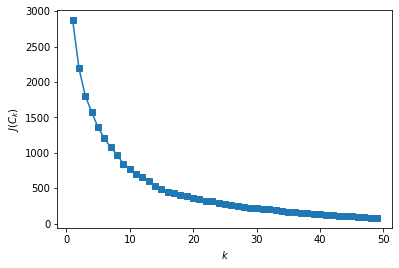

In [6]:
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 50): # 50 - из подсказки)
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(projections)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 50), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

- Видим явный сгиб в районе 13-14 кластеров

# Обучим  K-Means и визуализируем наши семплы

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13, random_state=random_state).fit(projections)
labels = kmeans.predict(projections)

Text(0.5, 1.0, 'MNIST. t-SNE projection')

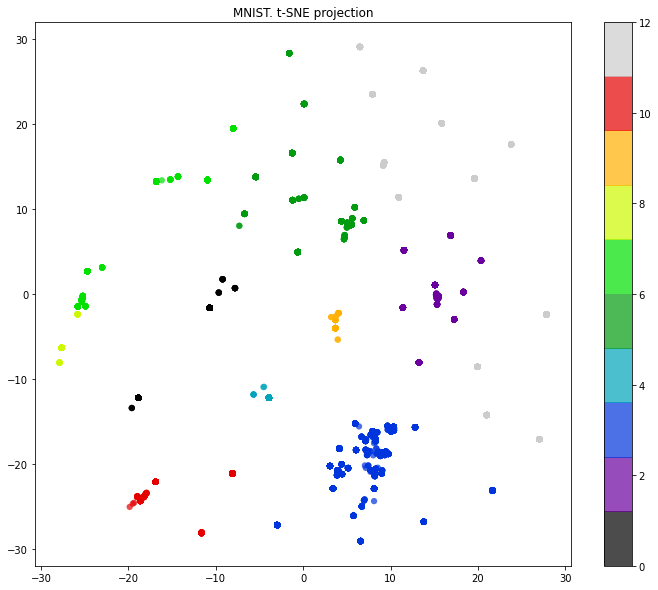

In [8]:
plt.figure(figsize=(12,10))
plt.scatter(projections[:, 0], projections[:, 1], c=labels, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

## Получилось довольно не плохо
- можно посмотреть на кластера поближе

In [9]:
train['label'] = labels

# Посмотрим на распределение по кластерам

In [10]:
pd.Series(labels).value_counts()

1     7021
4     2686
3     2516
0     2435
5     2021
10    1985
9     1967
2     1535
8     1529
7     1514
12    1257
6     1253
11     580
dtype: int64

# Информативные ли кластера получились относительно нашей концепции плохой/хороший запрос и получилось ли отделить мух от котлет

**Рассмотри результаты самого большого класса**

In [13]:
first_claster = train[labels==1]

- Видим что все CLIENT_USERAGENT - валидные (Кластер хороший)

In [14]:
first_claster

CLIENT_IP                                   CLIENT_USERAGENT  \
16       1.183.96.38  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...   
20       1.241.237.3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
28      1.65.170.222  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...   
30       10.1.72.122  Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...   
31         10.1.72.8  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
...              ...                                                ...   
28202  96.44.147.138  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28203   96.44.147.34  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28204  96.47.226.138  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28205   96.47.226.98  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
28208  97.77.151.155  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...   

      REQUEST_SIZE RESPONSE_CODE              MATCHED_VARIABLE_SRC  \
16             821           404                  REQUEST_GET_ARGS   
20            1726           404                  REQUEST_GET_ARGS   
28            1511           404                  REQUEST_GET_ARGS   
30             486           200      REQUEST_URI\';\'REQUEST_ARGS   
31            2277           302                 REQUEST_POST_ARGS   
...            ...           ...                               ...   
28202          946           200                  REQUEST_GET_ARGS   
28203         1174           200                  REQUEST_GET_ARGS   
28204         1046           200                  REQUEST_GET_ARGS   
28205         1112           200                  REQUEST_GET_ARGS   
28208          906           200  REQUEST_METHOD\';\'REQUEST_HEADE   

                           MATCHED_VARIABLE_NAME  \
16                            REQUEST_GET_ARGS._   
20                            REQUEST_GET_ARGS._   
28                            REQUEST_GET_ARGS._   
30                                          file   
31     ctl00$ContentPlaceHolder1$Login2$UserName   
...                                          ...   
28202                       REQUEST_GET_ARGS.st0   
28203                       REQUEST_GET_ARGS.rid   
28204                       REQUEST_GET_ARGS.rid   
28205                       REQUEST_GET_ARGS.rid   
28208            X-Requested-With\';\'CSRF_TOKEN   

                                  MATCHED_VARIABLE_VALUE  \
16                                         1516377129802   
20                                         1516163582259   
28                                             629963454   
30     /front/document.send.php?file=_dumps/..\\..\\....   
31                      <script>alert(\\\'\\\')</script>   
...                                                  ...   
28202                                            КУРУМОЧ   
28203                                         3549613985   
28204                                         3492421678   
28205                                         3517373430   
28208  POST\';\'XMLHttpRequest\';\'14ae90b529b45bd771...   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
16     Bk0PG2QB5cBXmMW1byzz         1         Chrome   Windows        Other   
20     UU9MG2QB5cBXmMW11SQf         1         Chrome   Windows        Other   
28     gLosJWQB5cBXmMW1jLyM         1         Chrome   Windows        Other   
30     MIE72mMBS0qQ_9B6qJiP         1         Chrome   Windows        Other   
31     UIE42mMBS0qQ_9B6-zow         1         Chrome   Windows        Other   
...                     ...       ...            ...       ...          ...   
28202  K2XxHWQB5cBXmMW1Sf8d         1         Chrome   Windows        Other   
28203  6ZxTImQB5cBXmMW1OhLw         1         Chrome   Windows        Other   
28204  _pbQIWQB5cBXmMW1cU5-         1         Chrome   Windows        Other   
28205  ME9SG2QB5cBXmMW1e1RQ         1         Chrome   Windows        Other   
28208  P0nU-GMBE91zVHe8bYdf         1         Chrome  

In [15]:
first_claster['CLIENT_USERAGENT'].value_counts().index[-100:]

Index(['Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36',
       'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36',
       'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.101 Safari/537.36',
       'Mozilla/5.0 (Windows; U; Windows NT 6.0) AppleWebKit/533.1.0 (KHTML, like Gecko) Chrome/38.0.832.0 Safari/533.1.0',
       'Mozilla/5.0 (Windows; U; Windows NT 5.1) AppleWebKit/533.1.1 (KHTML, like Gecko) Chrome/20.0.861.0 Safari/533.1.1',
       'Mozilla/5.0 (Windows; U; Windows NT 6.3) AppleWebKit/534.1.0 (KHTML, like Gecko) Chrome/16.0.880.0 Safari/534.1.0',
       'Mozilla/5.0 (Windows; U; Windows NT 6.0) AppleWebKit/533.1.0 (KHTML, like Gecko) Chrome/13.0.830.0 Safari/533.1.0',
       'Mozilla/5.0 (Windows; U; Windows NT 6.2) AppleWebKit/534.1.2 (KHTML, like Gecko) Chrome/27.0.856.0 Safari/534.1.2',
       'Mozilla/5.0 

- Все IP хорошие

In [18]:
# тут все VALID_IP = 0 IPV6 (видимо скрипт проверки IP это не учитывает)
first_claster[first_claster['VALID_IP'] == 0]

CLIENT_IP  \
9601   2001:7d0:87e2:1480:e870:b625:397   
13465  2a00:1370:8120:29a1:e89b:bb06:6f   
13466  2a00:1370:8120:29a1:f100:f51c:9a   
13467  2a00:1370:812a:1379:3d16:a3b4:88   
13493  2a02:2168:1b49:d900:71e7:9ac2:bf   
13496  2a02:2168:e4e:2300:b6a:2db3:fc95   
13497  2a02:2168:f55:1b00:c589:6624:fb4   
13498  2a02:2698:3c23:65d4:1839:9c8f:ef   
13499  2a02:2698:4c27:37bd:846c:d5bd:49   
13501  2a02:2698:7022:939a:c473:f721:9d   
13502  2a02:2698:7c25:f4dc:409e:83aa:61   

                                        CLIENT_USERAGENT REQUEST_SIZE  \
9601   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          602   
13465  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          623   
13466  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...         2122   
13467  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...         1159   
13493  Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...          454   
13496  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          913   
13497  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...          673   
13498  Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...          575   
13499  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          529   
13501  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          611   
13502  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...          503   

      RESPONSE_CODE MATCHED_VARIABLE_SRC  \
9601            200         REQUEST_ARGS   
13465           200          REQUEST_URI   
13466           200          REQUEST_URI   
13467           200          REQUEST_URI   
13493           200          REQUEST_URI   
13496           200    REQUEST_ARGS_KEYS   
13497           200         REQUEST_ARGS   
13498           200          REQUEST_URI   
13499           200         REQUEST_ARGS   
13501           200         REQUEST_ARGS   
13502           200          REQUEST_URI   

                                   MATCHED_VARIABLE_NAME  \
9601                                              action   
13465                                               None   
13466                                               None   
13467                                               None   
13493                                               None   
13496  customPrice%5B0%5D%5B9%5D=1673&quantity%5B%5D=...   
13497                                             action   
13498                                               None   
13499                                              image   
13501                                                src   
13502                                               None   

                                  MATCHED_VARIABLE_VALUE  \
9601                    dlattach;attach=1073;type=avatar   
13465                     /php/zakaz/zakazSearchById.php   
13466                     /php/zakaz/addNewZakazToDb.php   
13467    /system/cms/themes/madbull/img/horiz_spacer.png   
13493             /system/galery/raboti/18sjg885vmk2.jpg   
13496  customPrice%5B0%5D%5B9%5D=1673&quantity%5B%5D=...   
13497                       profile;area=showposts;u=785   
13498                       /tmp/korporacia_monstr_1.jpg   
13499                        ../imgbasa/483326241916.jpg   
13501                ./../../img/catalogue/item_0768.jpg   
13502                  /www/solutions/09/04/image012.png   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
9601   AVdii6k-q1Ppo9zF506m         0         Chrome   Windows        Other   
13465  AVdWvoUGq1Ppo9zFzP64         0         Chrome   Windows        Other   
13466  AVdm96rgq1Ppo9zF8a8l         0         Chrome   Windows        Other   
13467  AVdhXSutq1Ppo9zF5F4y         0         Chrome   Windows        Other   
13493  AVdl4dgCq1Ppo9zF7qsE         0         Chrome   Windows        Other   
13496  AVdbuRONq1Ppo9zF2HYt         0         Chrome   Windows        Other   
13497  AVdf3ucFq1Ppo9zF4nvF         0         Chrome   Windows        Other   
13498  AVddRxUjq1Ppo9zF3E1q      

**Исходя из этого можно сделать вывод, что этот кластер содержит в себе хорошие запросы (IP + User Agent),  это наши котлеты =)**

In [19]:
second_claster = train[labels==4]

**У второго по частоте кластера с валидность IP + User Agent тоже все хорошо, разлица в кластерах лишь в том, что они поделились по браузерам**

In [22]:
second_claster

CLIENT_IP                                   CLIENT_USERAGENT  \
13       1.160.23.57  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
14     1.165.182.173  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
18      1.221.120.99  Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...   
21       1.33.41.230  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
24      1.47.204.248  Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...   
...              ...                                                ...   
28196    95.96.35.94  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
28197    96.242.8.98  Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-PT...   
28206   97.127.71.98  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   
28207  97.74.230.213  Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) ...   
28210  98.163.108.72  Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...   

      REQUEST_SIZE RESPONSE_CODE          MATCHED_VARIABLE_SRC  \
13             778           200              REQUEST_GET_ARGS   
14             295           301              REQUEST_GET_ARGS   
18             681           200              REQUEST_GET_ARGS   
21             445           302              REQUEST_GET_ARGS   
24            1287           404               REQUEST_COOKIES   
...            ...           ...                           ...   
28196          376           301              REQUEST_GET_ARGS   
28197         1275           200              REQUEST_GET_ARGS   
28206          388           302              REQUEST_GET_ARGS   
28207          494           200  REQUEST_URI\';\'REQUEST_ARGS   
28210          390           302              REQUEST_GET_ARGS   

            MATCHED_VARIABLE_NAME  \
13                            url   
14                           addr   
18                        discuss   
21                            url   
24     REQUEST_COOKIES.LtpaToken2   
...                           ...   
28196                        addr   
28197                          id   
28206                         url   
28207             forgot_password   
28210                         url   

                                  MATCHED_VARIABLE_VALUE  \
13     bottompics.uadmin.isaev.info/?a[]=<a href=http...   
14                                    http://ix.sk/yjvjv   
18     999999.9 /**/uNiOn/**/aLl /**/sElEcT null,null...   
21     http://formulaforum.be/wiki/index.php?title=Fo...   
24     fFZdg/9zO1QozMBym9IW1cIp8kAoPxewbIauoR/pn1pOzN...   
...                                                  ...   
28196                         http://firsturl.de/4H17i9h   
28197  63164 or 1=(/**/sElEcT 1 /**/fRoM(/**/sElEcT c...   
28206                         http://firsturl.de/49ZIp7I   
28207  /notification/442225.php?el_id=442225&forgot_p...   
28210                         http://firsturl.de/3Dd55Dj   

                   EVENT_ID  VALID_IP BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
13     AVdoiBA1q1Ppo9zF9JLt         1        Firefox   Windows        Other   
14     AVdkTMGOq1Ppo9zF6sqm         1        Firefox   Windows        Other   
18     AVdmAw5bq1Ppo9zF7vnd         1        Firefox   Windows        Other   
21     AVdwGx13q1Ppo9zFAsX0         1        Firefox   Windows        Other   
24     q7WqJGQB5cBXmMW16UWX         1        Firefox   Windows        Other   
...                     ...       ...            ...       ...          ...   
28196  AVdpD1mLq1Ppo9zF9Ttq         1        Firefox   Windows        Other   
28197  AVdcW8-Pq1Ppo9zF2iLx         1        Firefox   Windows        Other   
28206  AVdnzX7yq1Ppo9zF81Fs         1        Firefox   Windows        Other   
28207  YlGFG2QB5cBXmMW1TgTx         1        Firefox   Windows        Other   
28210  AVdcv-PQq1Ppo9zF2zZn         1        Firefox   Windows        Other   

       SUSPICIOUS_DATA  INVALID_SIZE  INVALID_CODE  label  
13                   0             0             0      4  
14                   0             0             0      4  
18                   0

In [23]:
second_claster['BROWSER_FAMILY'].value_counts()

Firefox    2686
Name: BROWSER_FAMILY, dtype: int64

In [24]:
first_claster['BROWSER_FAMILY'].value_counts()

Chrome    7021
Name: BROWSER_FAMILY, dtype: int64

**Третиий по величине кластер также имеет валидные IP и CLIENT_USERAGENT, криетерием разбиения судя по всему явился Device Brand**

In [26]:
third_claster = train[labels==3]

In [31]:
third_claster['DEVICE_BRAND'].value_counts()

Samsung                   930
Generic_Android           343
XiaoMi                    250
Lenovo                    189
Huawei                    163
Generic_Android_Tablet    115
Generic                    91
Other                      86
Asus                       70
ZTE                        52
Sony                       52
LG                         36
HTC                        34
Micromax                   13
Nokia                      11
Philips                    11
Fly                         8
Prestigio                   8
SonyEricsson                7
Alcatel                     7
Spider                      6
Acer                        6
OnePlus                     3
Texet                       3
Oppo                        2
IconBIT                     2
Jiayu                       2
Haier                       2
Pantech                     1
Advent                      1
Odys                        1
Thl                         1
vivo                        1
Pipo      

In [32]:
first_claster['DEVICE_BRAND'].value_counts()

Other    7021
Name: DEVICE_BRAND, dtype: int64

In [33]:
second_claster['DEVICE_BRAND'].value_counts()

Other    2686
Name: DEVICE_BRAND, dtype: int64

In [35]:
print(first_claster[first_claster['DEVICE_BRAND'] == 'Other'].shape, first_claster.shape)
print(second_claster[second_claster['DEVICE_BRAND'] == 'Other'].shape, second_claster.shape)

(7021, 16) (7021, 16)
(2686, 16) (2686, 16)


# В каком кластере плохие запросы?

10й кластер содержит подозрительные и плохие запросы

In [60]:
train[train['label'] == 10]

CLIENT_IP                                   CLIENT_USERAGENT  \
42       101.0.109.194                                         Opera/9.27   
48       101.37.77.165                                         Opera/9.27   
61       103.199.2.200                                         Opera/9.27   
64     103.208.220.130           Mozilla/5.0 [en] (X11, U; OpenVAS 8.0.9)   
70       103.255.179.9                                               Ruby   
...                ...                                                ...   
28063       95.78.56.8  Mozilla/5.0 (Linux; Android 5.1.1; SM-G531F Bu...   
28085    95.79.188.107             sqlmap/1.0.8.2#dev (http://sqlmap.org)   
28116    95.81.210.168  Mozilla/5.0 (Linux; Android 7.0; SM-A310F Buil...   
28131     95.83.188.14                                               None   
28177      95.85.7.113                              python-requests/2.9.1   

      REQUEST_SIZE RESPONSE_CODE          MATCHED_VARIABLE_SRC  \
42             270           200              REQUEST_GET_ARGS   
48             272           403              REQUEST_GET_ARGS   
61             297           200              REQUEST_GET_ARGS   
64             469           404  REQUEST_URI\';\'REQUEST_ARGS   
70             537           403              REQUEST_GET_ARGS   
...            ...           ...                           ...   
28063          972           404              REQUEST_GET_ARGS   
28085          710           200              REQUEST_GET_ARGS   
28116          873           404               REQUEST_COOKIES   
28131          181           502                  REQUEST_ARGS   
28177         1191           301                  REQUEST_ARGS   

        MATCHED_VARIABLE_NAME  \
42                         ID   
48                      catid   
61                 categoryid   
64                        dsn   
70                     userid   
...                       ...   
28063      REQUEST_GET_ARGS._   
28085                      id   
28116  REQUEST_COOKIES.__gads   
28131                    path   
28177                    mail   

                                  MATCHED_VARIABLE_VALUE  \
42                                        7864&&SlEEp(3)   
48                                    0\'&&sLEEp(3)&&\'1   
61                                                     1   
64     /openmairie_Tel/scr/soustab.php?dsn[phptype]=....   
70     1 AND(SELECT 1 FROM (SELECT COUNT(*),CONCAT((S...   
...                                                  ...   
28063                                          184151269   
28085  1' AND (SELECT 2*(IF((SELECT * FROM (SELECT CO...   
28116  ID=d43d5faeba0ae234:T=1506874622:S=ALNI_MZP_cV...   
28131                        ../htm/book_rot/images.book   
28177  echo Y3JvbnRhYiAtciA7IGNkIC92YXIvdG1wLyA7IC91c...   

                   EVENT_ID  VALID_IP   BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  \
42     AVds8fX7q1Ppo9zF_Us_         1            Opera     Other        Other   
48     3P33BGQBjksgoq1eL0E5         1            Opera     Other        Other   
61     AVdiyVR5q1Ppo9zF5-UG         1            Opera     Other        Other   
64     L-f_AmQBjksgoq1eJ_hL         1  OpenVAS Scanner     Other        Other   
70     ov4ZBWQBjksgoq1e_2Yg         1            Other     Other        Other   
...                     ...       ...              ...       ...          ...   
28063  a68KJGQB5cBXmMW1WQCR         1    Chrome Mobile   Android      Samsung   
28085  AVdqZA3cq1Ppo9zF9_rW         1            Other     Other        Other   
28116  X05BG2QB5cBXmMW1RsMK         1    Chrome Mobile   Android      Samsung   
28131  AVdQUKCpq1Ppo9zFy0wI         1            Other     Other        Other   
28177  YzITNmYBrgKk_RFNBVZ2         1  Python Requests     Other        Other   

       SUSPICIOUS_DATA  INVALID_SIZE  INVALID_CODE  label  
42                   0             0             0     10  
48                   0             0             0     10  
61                   0  

11й класс - попали наши плохие запросы

In [63]:
train[train['label'] == 11]

CLIENT_IP  \
0           ý9g³~7ǼAy~è ÷RN1^¤ZϥØÝ
D
FÎ
´
>|   
1                                       >±nß×a¢7ý   
2      ©¬¤\n¸/óîêkOÎÀ
ôzZt©qøӚUÊf©yßSX...   
3      ò­U¬̃ÐÔêsP¯ݦ´ֻڋCü©\tÄ àÔf²kP½z®sn¾ſô#...   
4      \n¨Àç۷­|Ó\r¼Ł;z¢±Ç×íVë¨'2yKï#rïyúÔX»R薲s...   
...                                                  ...   
28294                             ìújHß.V膢6óã!M]óO÷çIæÿ   
28295  õt2AbÅX;àúT~Á_¥äÆñ§â¦Qý*ù¥ÝýáeØð϶ÜÛæ|¾...   
28296                ù8­<#ÏÏßØÓÆ3rö¦f·۠3M¨L'ÜTؒBõ   
28297                                      ƬÕîzü5ûyÿ   
28298                                                րÿ   

           CLIENT_USERAGENT          REQUEST_SIZE  \
0      AVdtAee3q1Ppo9zF_WoF                  None   
1             SQL Injection  AVdd0K2Rq1Ppo9zF3bg5   
2             SQL Injection  AVdZArWNq1Ppo9zF0txd   
3             SQL Injection  AVdnRu2fq1Ppo9zF8qCY   
4             SQL Injection  AVdfPawjq1Ppo9zF4R4n   
...                     ...                   ...   
28294         SQL Injection  AVdn_D9xq1Ppo9zF87Z-   
28295                  None                  None   
28296                  None                  None   
28297  AVdieeEhq1Ppo9zF5x8y                  None   
28298  AVdo4TiJq1Ppo9zF9OU0                  None   

                          RESPONSE_CODE MATCHED_VARIABLE_SRC  \
0                                  None                 None   
1      81313b14c79a583f202f1ffb179e1f32                 None   
2      96354d8ea79d95995f807edcbc6772b2                 None   
3      82b4c42ac7edc647d27de21ceb791491                 None   
4      5cae7339ed82e2077c9a5da7c92c698a                 None   
...                                 ...                  ...   
28294  0b809ae29d22329a1ca3353f675e3dcf                 None   
28295                              None                 None   
28296                              None                 None   
28297                              None                 None   
28298                              None                 None   

      MATCHED_VARIABLE_NAME MATCHED_VARIABLE_VALUE EVENT_ID  VALID_IP  \
0                      None                   None     None         0   
1                      None                   None     None         0   
2                      None                   None     None         0   
3                      None                   None     None         0   
4                      None                   None     None         0   
...                     ...                    ...      ...       ...   
28294                  None                   None     None         0   
28295                  None                   None     None         0   
28296                  None                   None     None         0   
28297                  None                   None     None         0   
28298                  None                   None     None         0   

      BROWSER_FAMILY OS_FAMILY DEVICE_BRAND  SUSPICIOUS_DATA  INVALID_SIZE  \
0              Other     Other        Other                1             1   
1              Other     Other        Other                1             1   
2              Other     Other        Other                1             1   
3              Other     Other        Other                1             1   
4              Other     Other        Other                1             1   
...              ...       ...          ...              ...           ...   
28294          Other     Other        Other                1             1   
28295          Other     Other        Other                1             1   
28296          Other     Other        Other                1             1   
28297          Other     Other        Other                1             1   
28298          Other     Other        Other                1             1   

       INVALID_CODE  label  
0                 0     11  
1                 1     11  
2                 1

- Видим что тут много compatible (поисковые роботы) и SQL Injection

In [64]:
train[train['label'] == 11]['CLIENT_USERAGENT'].value_counts()

Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                                                           116
Mozilla/5.0 (compatible; MJ12bot/v1.4.5; http://www.majestic12.co.uk/bot.php?+)                                                                    103
Mozilla/5.0 (compatible; Linux x86_64; Mail.RU_Bot/2.0; +http://go.mail.ru/help/robots)                                                             37
SQL Injection                                                                                                                                       35
Mozilla/5.0 (compatible; SputnikBot/2.3; +http://corp.sputnik.ru/webmaster)                                                                         34
                                                                                                                                                  ... 
Mozilla/5.0 (iPhone; CPU iPhone OS 11_1_2 like Mac OS X) AppleWebKit/604.1.34 (KHTML, like Gec

- 12й кластер также один из плохих, много роботов 

In [61]:
train[train['label'] == 12]['CLIENT_USERAGENT'].value_counts()

Mozilla/5.0 (compatible; AhrefsBot/5.2; +http://ahrefs.com/robot/)                                                                                            731
Mozilla/5.0 (compatible; AhrefsBot/5.1; +http://ahrefs.com/robot/)                                                                                            345
Mozilla/5.0 (Linux; Android 4.4.2; HTC Desire 626G dual sim Build/KOT49H) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.111 Mobile Safari/537.36      4
Mozilla/5.0 (Linux; Android 6.0; ZTE BLADE V7 Build/MRA58K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.111 Mobile Safari/537.36                    3
Mozilla/5.0 (Linux; Android 6.0; ZTE BLADE A510 Build/MRA58K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.111 Mobile Safari/537.36                  3
                                                                                                                                                             ... 
Mozilla/5.0 (Linux; Android 

# Save model

In [68]:
import joblib

In [72]:
_, enc = create_cat_features(train, cat_colls)

/Users/u18571158/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [73]:
joblib.dump(enc, "src/models/weights/one_hot_enc.joblib")
joblib.dump(embedding_train, "src/models/weights/tsne.joblib")
joblib.dump(kmeans, "src/models/weights/kmeans.joblib")

['src/models/weights/kmeans.joblib']

In [75]:
train.to_csv('result.csv',index=False)